# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [3]:
df_content.doc_full_name=df_content.doc_full_name.str.lower()

In [4]:
merged_df=pd.merge(df_content, df[['article_id', 'title']].drop_duplicates(), left_on='doc_full_name', right_on='title')

In [5]:
merged_df.apply(lambda row: row.article_id_x == row.article_id_y, axis=1).all()

True

The df and df_content dataframes contain differing sets articles. I had worried the article id's might be wrong but they do match on titles.

### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [6]:
df_no_title=df.drop('title', axis=1)
user_view_counts=df_no_title.groupby('email').count()
user_view_counts.columns=['Views']
article_view_counts=df_no_title.groupby('article_id').count()
article_view_counts.columns=['Views']
user_view_counts.head()

,Views
email,
0000b6387a0366322d7fbfc6434af145adf7fed1,13
001055fc0bb67f71e8fa17002342b256a30254cd,4
00148e4911c7e04eeff8def7bbbdaf1c59c2c621,3
001a852ecbd6cc12ab77a785efa137b2646505fe,6
001fc95b90da5c3cb12c501d201a915e4f093290,2


In [7]:
print(user_view_counts.median())
user_view_counts.describe()

Views    3.0
dtype: float64


,Views
count,5148.000000
mean,8.930847
std,16.802267
min,1.000000
25%,1.000000
50%,3.000000
75%,9.000000
max,364.000000


In [8]:
article_view_counts.head()

,Views
article_id,
0.0,14
2.0,58
4.0,13
8.0,85
9.0,10


In [9]:
# Fill in the median and maximum number of user_article interactios below

median_val = 3# 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user =364 # The maximum number of user-article interactions by any 1 user is ______.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [10]:
# Find and explore duplicate articles
dupes=df_content.groupby('article_id').count().iloc[:,0] > 1
dupes[dupes].head()

article_id
50     True
221    True
232    True
398    True
577    True
Name: doc_body, dtype: bool

In [11]:
duplicated=df_content.set_index('article_id').sort_index()[dupes]
print(duplicated.shape)
duplicated

(10, 4)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,doc_body,doc_description,doc_full_name,doc_status
article_id,,,,
50,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,graph-based machine learning,Live
50,Follow Sign in / Sign up Home About Insight Da...,Community Detection at Scale,graph-based machine learning,Live
221,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,how smart catalogs can turn the big data flood...,Live
221,* United States\r\n\r\nIBM® * Site map\r\n\r\n...,When used to make sense of huge amounts of con...,how smart catalogs can turn the big data flood...,Live
232,Homepage Follow Sign in Get started Homepage *...,"If you are like most data scientists, you are ...",self-service data preparation with ibm data re...,Live
232,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",self-service data preparation with ibm data re...,Live
398,Homepage Follow Sign in Get started * Home\r\n...,Today’s world of data science leverages data f...,using apache spark as a parallel processing fr...,Live
398,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,using apache spark as a parallel processing fr...,Live
577,This video shows you how to construct queries ...,This video shows you how to construct queries ...,use the primary index,Live


In [12]:
for idx in set(duplicated.index):
    print(idx)
    print(duplicated.loc[idx].iloc[0]==duplicated.loc[idx].iloc[1])

577
doc_body           False
doc_description    False
doc_full_name       True
doc_status          True
Name: 577, dtype: bool
232
doc_body           False
doc_description     True
doc_full_name       True
doc_status          True
Name: 232, dtype: bool
398
doc_body           False
doc_description     True
doc_full_name       True
doc_status          True
Name: 398, dtype: bool
50
doc_body           False
doc_description    False
doc_full_name       True
doc_status          True
Name: 50, dtype: bool
221
doc_body           False
doc_description    False
doc_full_name       True
doc_status          True
Name: 221, dtype: bool


In [13]:
# Remove any rows that have the same article_id - only keep the first
df_content=df_content.sort_values('article_id').drop_duplicates('article_id',keep='first').set_index('article_id')

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [14]:
df_content.shape

(1051, 4)

In [15]:
print(article_view_counts.shape)
print(df_content.shape)
print(user_view_counts.shape)
print(df.shape)

(714, 1)
(1051, 4)
(5148, 1)
(45993, 3)


In [16]:
unique_articles = 714 # The number of unique articles that have at least one interaction
total_articles = 1051 # The number of unique articles on the IBM platform
unique_users = 5148# The number of unique users
user_article_interactions = 45993 # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [17]:
article_view_counts.sort_values('Views').iloc[-5:]

,Views
article_id,
1364.0,627
1427.0,643
1431.0,671
1330.0,927
1429.0,937


In [18]:
most_viewed_article_id = '1429.0'# The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937# The most viewed article in the dataset was viewed how many times?

In [19]:
df=df[~df.email.isnull()]

In [20]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [21]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [22]:
def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    article_view_counts=df.groupby('article_id').count().iloc[:,0].copy()
    article_view_counts.sort_values(ascending=False,inplace=True)
    top_articles=article_view_counts.head(n).index
    return list(top_articles) # Return the top article titles from df (not df_content)

def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    top_articles=get_top_article_ids(n, df)
    top_articles= df.set_index('article_id').loc[top_articles,'title'].drop_duplicates().values
        
    return list(top_articles) # Return the top article ids

In [23]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [24]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [25]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    user_item=df.groupby(['user_id', 'article_id']).apply(lambda x: 1).unstack().fillna(0)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [26]:
print(user_item.shape)
print(user_item.sum(axis=1)[1])
user_item.head(10)

(5148, 714)
36.0


article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5148, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [28]:
from numpy.linalg import norm

In [29]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest cosine angle)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the cosine angle
    Returns an ordered list
    If user has no interactions, returns users ordered by similarity between their interactions
    and the popularity of articles
    
    '''
    # compute similarity of each user to the provided user
    try:
        user_views=user_item.loc[user_id].values
        user_item=user_item.drop(user_id)
    except:
        user_views=np.array([])
    norms=user_item.apply(norm, axis=1)
    total_views=user_item.sum()
    
    if norm(user_views)==0:
        user_views=total_views
          
    dots=np.dot(user_views,user_item.values.transpose())
    user_item['cosine']=dots/(norm(user_views)*norms.values)
    # sort by similarity
    user_item.sort_values('cosine', inplace=True, ascending=False)
    # create list of just the ids
    most_similar_users=list(user_item.index)
    
    return most_similar_users # return a list of the users in order from most to least similar

        

In [30]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3932, 4200, 46, 824, 253, 5033, 5040, 136, 2305, 395]
The 5 most similar users to user 3933 are: [2742, 1530, 2351, 877, 2864]
The 3 most similar users to user 46 are: [4200, 790, 5076]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [31]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Your code here
    articles=df.set_index('article_id').loc[article_ids,'title'].drop_duplicates()
    article_names=list(articles.values)
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item, names=True):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Your code here
    viewed=user_item.loc[user_id,(user_item.loc[user_id]==1)].index
    article_ids=list(viewed)
    if names:
        article_names=get_article_names(article_ids)
        return article_ids, article_names # return the ids and names
    else:
        return article_ids

def make_recs_from_similar(similar, m=10):
    recs=[]
    
    while (len(recs) < m or m==-1) and len(similar) > 0:
        similar_user=similar.pop()
        possible_recs=get_user_articles(similar_user, names=False)
        while (len(recs) < m or m==-1) and len(possible_recs) > 0:
            rec=possible_recs.pop()
            if rec in recs:
                continue
            else:
                recs.append(rec)
    return recs

def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Your code here
    
    similar=find_similar_users(user_id)
    recs=make_recs_from_similar(similar, m)
    
    return recs # return your recommendations for this user_id    

In [32]:
user_user_recs(1, m=10)

[16.0, 350.0, 784.0, 426.0, 120.0, 92.0, 1386.0, 1433.0, 1405.0, 122.0]

In [33]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names([1024.0, 1176.0, 1305.0, 1314.0, 1422.0, 1427.0])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names([1320.0, 232.0, 844.0])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set([1320.0, 232.0, 844.0])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set([1024.0, 1176.0, 1305.0, 1314.0, 1422.0, 1427.0])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [34]:
def get_top_sorted_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Your code here
    try:
        user_views=user_item.loc[user_id].values
        user_item=user_item.drop(user_id)
    except:
        user_views=np.array([])
    
    norms=user_item.apply(norm, axis=1)
    total_views=user_item.sum()
    
    if norm(user_views)==0:
        user_views=total_views
          
    dots=np.dot(user_views,user_item.values.transpose())
    
    user_item['dot_product']=dots
    
    view_counts=df.groupby('user_id').count().iloc[:,0].copy().drop(user_id)
    view_counts.sort_values(ascending=False,inplace=True)
    view_counts.name='views'
    
    neighbors_df=pd.concat([view_counts, user_item['dot_product']], axis=1).sort_values(['dot_product', 'views'], ascending=False)
    
    return neighbors_df  # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10, df=df):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Your code here
    similar=list(get_top_sorted_users(user_id).index)
    recs=make_recs_from_similar(similar,m)
    rec_names=get_article_names(recs, df)
    
    return recs, rec_names

In [35]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[16.0, 1160.0, 233.0, 270.0, 189.0, 146.0, 1330.0, 53.0, 8.0, 224.0]

The top 10 recommendations for user 20 are the following article names:
['higher-order logistic regression for large datasets', 'analyze accident reports on amazon emr spark', 'bayesian nonparametric models – stats and bots', 'learning statistics on youtube', 'common excel tasks demonstrated in\xa0pandas', 'how to use db2 warehouse on cloud in data science experience notebooks', 'insights from new york car accident reports', 'introducing streams designer', 'data science bowl 2017', 'using apply, sapply, lapply in r']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [36]:
get_top_sorted_users(1).iloc[:2,:]

,views,dot_product
user_id,,
3932,45,35.0
23,364,17.0


In [37]:
get_top_sorted_users(131).iloc[9]

views          148.0
dot_product     25.0
Name: 242, dtype: float64

In [38]:
### Tests with a dictionary of results

user1_most_sim = 3933 # Find the user that is most similar to user 1 (+1 because I dropped NaN emails)
user131_10th_sim = 242 #Find the 10th most similar user to user 131

In [39]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Provide your response here.**

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [40]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs =get_top_article_ids(10) # Your recommendations here



In [41]:
assert set(new_user_recs) == set([1314.0,1429.0,1293.0,1427.0,1162.0,1364.0,1304.0,1170.0,1431.0,1330.0]), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [42]:
import nltk
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('wordnet')

from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import auc
from scipy.linalg import subspace_angles
from sklearn.metrics.pairwise import cosine_similarity

import re
from urllib.parse import urlparse

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [43]:
def extract_url_data(url):
    """Extract hostname and path from url if possible"""
    dat=urlparse(url)
    if dat.hostname:
        return [x for x in [dat.hostname.strip('www.'), dat.path.strip('/')] if x]
    else:
        dat=urlparse('//'+url)
        return [x for x in [dat.hostname.strip('www.'), dat.path.strip('/')] if x]
url_pattern = r"(?i)\b((?:[a-z][\w-]+:(?:/{1,3}|[a-z0-9%])|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'\".,<>?«»“”‘’]))"
stopWords=stopwords.words('english')
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(tag):
    """ Pos tag to Wordnet tag """
    tag=tag[0].upper()
    if tag == 'J':
        return wordnet.ADJ
    elif tag == 'V':
        return wordnet.VERB
    elif tag == 'N':
        return wordnet.NOUN
    elif tag == 'R':
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [44]:
def tokenize(text, suffix=''):
    """Clean and tokenize text, then lemmatize. Label with suffix if given"""
    text = text.lower()

    ##urls
    text=re.sub(r"\[|\]", ' ', text) #They break the regex for some reason

    matcher= re.compile(url_pattern)
    urls=[match.group() for match in matcher.finditer(text)]
    for url in urls:
        text=text.replace(url, ' ', 1)

    url_tokens=sum([extract_url_data(url) for url in urls], [])

    ##Remove punctuation and tokenize
    text = re.sub(r"[^a-zA-Z]", " ", text)

    word_tokens=word_tokenize(text)
    ##Lemmatise
    word_tokens = [lemmatizer.lemmatize(word,get_wordnet_pos(tag)) for word,tag in pos_tag(word_tokens) if word not in stopWords]
    #word_tokens = [lemmatizer.lemmatize(word) for word in word_tokens if word not in stopWords]
    return [token+suffix for token in (url_tokens+word_tokens)]

def tokenizer(suffix):
    '''Tokenize wrapper'''
    return (lambda text: quick_tokenize(text,suffix=suffix))

def quick_tokenize(text, suffix=''):
    """Clean and tokenize text, then lemmatize"""
    text = text.lower()

    ##Remove punctuation and tokenize
    text = re.sub(r"[^a-zA-Z]", " ", text)

    word_tokens=word_tokenize(text)
    ##Lemmatise
    word_tokens = [lemmatizer.lemmatize(word,get_wordnet_pos(tag)) for word,tag in pos_tag(word_tokens) if word not in stopWords]
    #word_tokens = [lemmatizer.lemmatize(word) for word in word_tokens if word not in stopWords]
    return [token+suffix for token in word_tokens]

In [45]:
def transformer(suffix,vect=None):
    '''Make feature pipeline for text tokenisation'''
    if vect==None:
        vect=CountVectorizer(tokenizer=tokenizer(suffix))
        
    features=Pipeline([('pull_column', FunctionTransformer(lambda df : df['doc'+suffix], validate=False)),
                           ('vect', vect)])
    return features

In [46]:
df_content.fillna('', inplace=True)

In [47]:
def build_transformer(X, suffixes=['_body', '_description', '_full_name']):
    '''Text vectoriser + tfidf transform for given suffixes'''
    if len(suffixes) > 1:
        text_transformer=FeatureUnion([('transformer'+suffix,transformer(suffix)) for suffix in suffixes])
    else:
        text_transformer=transformer(suffixes[0])
        
    pipe=Pipeline([('text_vects', text_transformer),
                            ('tfidf', TfidfTransformer())])    
    X=pipe.fit_transform(X)
    return X, pipe

tfidf_df, text_transformer=build_transformer(df_content)

In [48]:
art_sim_mat=cosine_similarity(tfidf_df)
art_sim_df=pd.DataFrame(art_sim_mat, columns=df_content.index, index=df_content.index)

In [49]:
def build_keyword_transformer(X, suffixes=['_body', '_description'], key_suffix='_full_name'):
    '''Build, fit and transform keyword tranformer'''
    
    
    vect=CountVectorizer(tokenizer=tokenizer(key_suffix))

    key_transformer=transformer(key_suffix, vect)
    
    key_transformer.fit(X)
    
    key_word_transformer=FeatureUnion([('transformer'+key_suffix, key_transformer)]+
                                          [('transformer'+suffix,transformer(suffix, vect)) for suffix in suffixes])
    

    tfidf=TfidfTransformer()
    
    X_count=key_word_transformer.transform(X)
    
    X_tfidf=tfidf.fit_transform(X_count)
    
    pipe=Pipeline([('key_word_vects', key_word_transformer),
                            ('tfidf', tfidf)]) 
    
    return X_tfidf, pipe

#tfidf_df, text_transformer=build_keyword_transformer(df_content)

In [50]:
##Collect user lists
known_users=user_item.loc[:,:(df_content.shape[0]-1)].sum(axis=1) > 7 #Find suitable users for validation
known_users=list(user_item[known_users].index)
users=list(user_item.index) #All users

In [51]:
#User similarities for collaborative recommender reimplementation
user_sim_mat=cosine_similarity(user_item)
user_sim_df=pd.DataFrame(user_sim_mat, columns=users, index=users)
user_sim_df.head()

,1,2,3,4,5,6,7,8,9,10,...,5139,5140,5141,5142,5143,5144,5145,5146,5147,5148
1,1.000000,0.136083,0.158114,0.098058,0.000000,0.157135,0.117851,0.132453,0.121716,0.267652,...,0.138458,0.0,0.0,0.157135,0.0,0.074536,0.000000,0.0,0.000000,0.0
2,0.136083,1.000000,0.064550,0.240192,0.000000,0.192450,0.000000,0.054074,0.149071,0.374634,...,0.096900,0.0,0.0,0.000000,0.0,0.182574,0.000000,0.0,0.000000,0.0
3,0.158114,0.064550,1.000000,0.155043,0.091287,0.260875,0.111803,0.104713,0.057735,0.181369,...,0.131353,0.0,0.0,0.186339,0.0,0.141421,0.000000,0.0,0.000000,0.0
4,0.098058,0.240192,0.155043,1.000000,0.339683,0.369800,0.000000,0.207810,0.035806,0.179969,...,0.139648,0.0,0.0,0.092450,0.0,0.175412,0.074125,0.0,0.196116,0.0
5,0.000000,0.000000,0.091287,0.339683,1.000000,0.136083,0.000000,0.229416,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0


In [52]:
user_sim_df[1].sort_values(ascending=False).head(10)

1       1.000000
3932    0.986013
4200    0.342580
46      0.342580
5033    0.333333
824     0.333333
253     0.333333
5040    0.301511
2305    0.298142
136     0.298142
Name: 1, dtype: float64

In [53]:
def content_angle_recs(seen,sim_df=art_sim_df, agg=lambda x: x.mean(axis=1)):
    '''Content recommender based on cosine similarity'''
    
    unseen_sim=sim_df.drop(seen).loc[:,seen]
    agg_sim=agg(unseen_sim).sort_values(ascending=False)
    
    return agg_sim
def make_content_angle_recs(user, n, sim_df=art_sim_df, user_item=user_item, agg=lambda x: x.mean(axis=1)):
    '''
    Makes content recommendations.
    
    INPUT:
    user- (int) target of recommendations
    n - (int) number of recommendations
    sim_df - (df) article similarity matrix
    user_item - user/item interaction matrix
    agg = (row -> float) method for aggregating similarity scores
    
    OUTPUT:
    (list) n content based recommendations for user
    
    '''
    user_item=user_item.reindex(art_sim_df.columns, axis=1).dropna(axis=1)
    interactions=user_item.loc[user]
    seen=list(interactions[interactions ==1].index)
    agg_sim=content_angle_recs(seen, sim_df=sim_df, agg=lambda x: x.mean(axis=1))
    
    return list(agg_sim.index)[:n]

In [54]:
make_content_angle_recs(1,10) #Example

[124, 793, 892, 1025, 455, 800, 153, 1050, 164, 384]

In [55]:
def user_user_recs(user, seen, user_sim_df=user_sim_df, user_item=user_item,
                        weight=lambda rank: (1/2)**rank,
                        agg=lambda df: df.sum(axis=1)):
    '''Colloborative recommender based on user cosine similarity'''
    user_sims=user_sim_df[user].sort_values(ascending=False).drop(user)
    
    user_item=user_item.copy().drop(seen, axis=1)
    ranked_seen=[] 
    
    rank=1
    for user2 in user_sims.index:
        ranked_seen.append((weight(rank)*user_item.loc[user2]))
        rank+=1
    
    rank_df=agg(pd.concat(ranked_seen,axis=1)).sort_values(ascending=False)

    return rank_df

def make_user_user_recs(user, n, user_sim_df=user_sim_df, user_item=user_item,
                        weight=lambda rank: (1/2)**rank,
                        agg=lambda df: df.sum(axis=1)):
    '''
    Makes collobarative recommendations.
    
    Ranks other users by similarities. User/article interactions are then weighted by user rank and aggregated.
    
    INPUT:
    user- (int) target of recommendations
    n - (int) number of recommendations
    user_sim_df - (df) user  similarity matrix
    user_item - user/item interaction matrix
    weight - (int -> float) score contribution from being seen by user of a given similarity rank 
    agg = (row -> float) method for weighted interactions
    OUTPUT:

    '''
    
    interactions=user_item.loc[user]
    seen=list(interactions[interactions ==1].index)
    
    rank_df=user_user_recs(user,seen, user_sim_df, user_item,weight,agg)
    return list(rank_df.index)[:n]

In [56]:
make_user_user_recs(1,10) #Example

[1351.0, 1360.0, 1017.0, 1423.0, 933.0, 1393.0, 1364.0, 1162.0, 1164.0, 1054.0]

In [57]:
def combine(sims,weights):
    '''Function to combine content similarities with user/user weightings'''
    combo=pd.concat([(weights*sims*0.5),(0.5*sims)], axis=1).sum(axis=1)
    return combo

def user_content_recs(user, seen, user_sim_df=user_sim_df, user_item=user_item,
                        art_sim_df=art_sim_df, art_agg=lambda x: x.mean(axis=1),
                        user_weight=lambda rank: (1/2)**rank,
                        user_agg=lambda df: df.sum(axis=1),
                        combine=combine):
    
    '''Combinded colloborative + content based recommender'''
    
    content_sims=content_angle_recs(seen,art_sim_df, art_agg)
    collab_weights=user_user_recs(user, seen, user_sim_df, user_item,
                        weight=user_weight, agg=user_agg)
    weighted_sims=combine(content_sims, collab_weights).sort_values(ascending=False)
    return weighted_sims

def make_user_content_recs(user,n, user_sim_df=user_sim_df, art_sim_df=art_sim_df,
                        user_item=user_item, art_agg=lambda x: x.mean(axis=1),
                        user_weight=lambda rank: (1/2)**rank,
                        user_agg=lambda df: df.sum(axis=1),
                        combine=combine):
    '''
    Makes collobarative + content based recommendations.
    
    INPUT:
    user- (int) target of recommendations
    n - (int) number of recommendations
    user_sim_df - (df) user similarity matrix
    art_sim_df - (df) article similarity matrix
    user_item - (df) user/item interaction matrix
    art_agg - (row -> float) method for aggregating article similarity scores
    user_weight - (int -> float) score contribution from being seen by user of a given similarity rank 
    user_agg = (row -> float) method for aggregating weighted interactions
    combine = ((series,series) -> series) method for combining article_similarities and aggregated weights 
    OUTPUT:

    '''
        
    interactions=user_item.reindex(art_sim_df.columns, axis=1).dropna(axis=1).loc[user]
    seen=list(interactions[interactions ==1].index)
    
    weighted_sims=user_content_recs(user,seen, user_sim_df, user_item,
                        art_sim_df, art_agg, user_weight,
                        user_agg,combine)
    
    return list(weighted_sims.index)[:n]

In [58]:
user_train=user_item.loc[known_users,:(df_content.shape[0]-1)].copy()
test={}
seed=42

for user in known_users:
    interactions=user_train.loc[user]
    interactions=interactions[interactions==1]

    test[user]=list(interactions.sample(frac=0.25, random_state=seed).index)
    user_train.loc[user,test[user]]=0
    
    seed= seed+1
    
user_sim_mat_train=cosine_similarity(user_train)
user_sim_df_train=pd.DataFrame(user_sim_mat_train, columns=user_train.index, index=user_train.index)

In [59]:
tfidf_df, text_transformer=build_transformer(df_content,suffixes=['_description', '_full_name'])
art_sim_mat_train=cosine_similarity(tfidf_df)
art_sim_df_train=pd.DataFrame(art_sim_mat_train, columns=df_content.index, index=df_content.index)
art_sim_df_train=art_sim_df_train.loc[user_train.columns, user_train.columns]

In [60]:
def evaluate_recommender(recommender, test=test):
    '''
    Evaluates recommender against a test dictionary. Plots and outputs mean recall, precision and f1-scores.
    Also prints and outputs precision/recall auc score.
    '''
    recalls_list=[]
    precisions_list=[]

    for user in test.keys():   
        recs=recommender(user)
    
        precisions=[]
        recalls=[]
        is_pos=[rec in test[user] for rec in recs]
    
        for i in range(1,900):
            n_true= sum(is_pos[:i])
            precision= n_true/i
            recall=n_true/len(test[user])
        
            precisions.append(precision)
            recalls.append(recall)
        
        recalls_list.append(recalls)
        precisions_list.append(precisions)
    
    mean_precisions=np.array([np.mean(x) for x in np.array(precisions_list).transpose()])
    mean_recalls=np.array([np.mean(x) for x in np.array(recalls_list).transpose()])
    f1_scores=2*(mean_precisions*mean_recalls)/(mean_precisions+mean_recalls)

    f, axs = plt.subplots(2,2,figsize=(12,12))
    
    xlim=100
    plt.subplot(2,1,1)
    plt.plot(range(1,xlim+1), mean_precisions[:xlim])
    plt.plot(range(1,xlim+1), mean_recalls[:xlim])
    plt.plot(range(1,xlim+1), f1_scores[:xlim])
    plt.legend(['Precision', 'Recall', 'f1_score'])
    plt.title('Precision, Recall and f1-score vs Number of Predictions')
    plt.ylabel('Score')
    plt.xlabel('Predictions')
    
    
    plt.subplot(2,1,2)    
    plt.plot(mean_recalls, mean_precisions);
    plt.title('Precision vs Recall')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    
    auc_score=auc(range(1,900), mean_precisions)
    print(f'Precision/Number of Predicitions auc score: {auc_score}')
          
    auc_score=auc(mean_recalls, mean_precisions)
    print(f'Precision/Recall auc score: {auc_score}')
    return mean_precisions, mean_recalls, f1_scores, auc_score

Precision/Number of Predicitions auc score: 18.79648198039365
Precision/Recall auc score: 0.30946207272236526


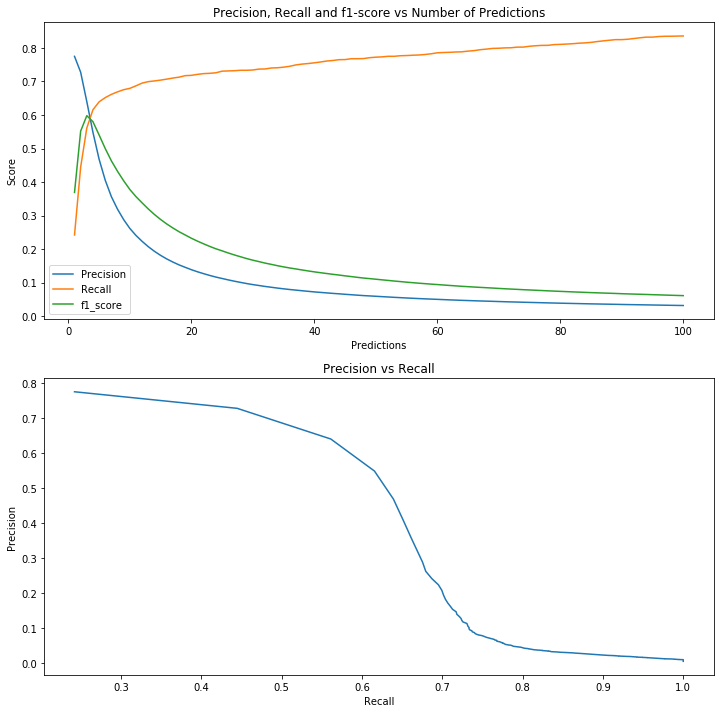

In [61]:
recommender= lambda user: make_user_user_recs(user,-1, user_sim_df_train, user_train)
evaluate_recommender(recommender,test);

Precision/Number of Predicitions auc score: 8.021604808960213
Precision/Recall auc score: 0.01352498923654916


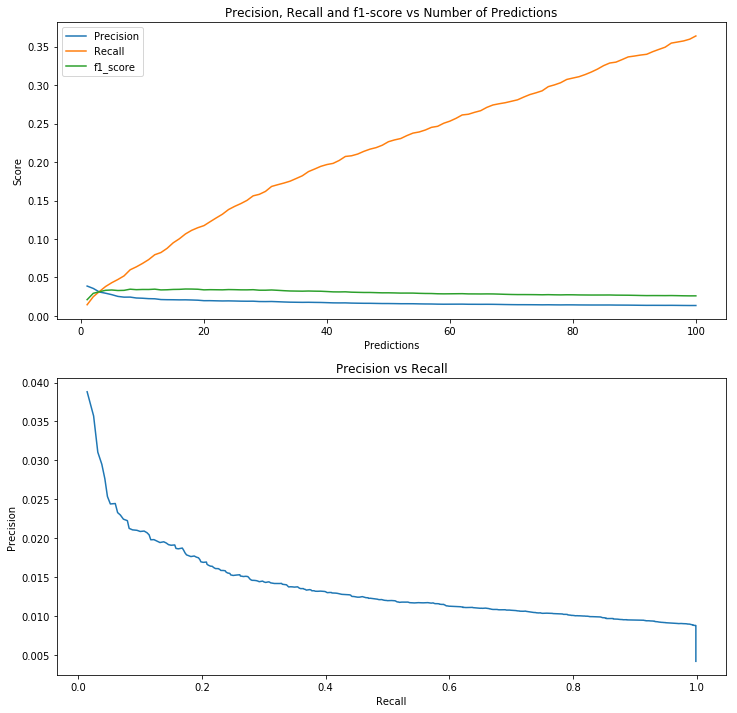

In [62]:
recommender =lambda user: make_content_angle_recs(user,-1, art_sim_df_train, user_train)
evaluate_recommender(recommender);

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**

The content based recommendation was done by basic tokenization with nltk. A Tfidf was used on the resulting word counts. This was not ideal, the doc_body included a load of unrelated data. It included for example text for log in and search buttons in some entries. Because the content of extraneous data varied from entry to entry it may reduce the accuracy of the similarity scores, I also couldn't see a good way of removing the data because I had no good description of what was relevant and what was not. In the end I opted not to use the doc_body field.

One option I explored was to train a count vectoriser on only the title or the title + description entries and then use it to transform the doc_body, the logic being they probably contain all the keywords. This was a slight improvement but there wasn't much in it. Another option might be to train a model to predict whether a given user viewed an article based upon the tfidf matrix, then use this to pull out the most relevant words and only use these.

I also rebuilt the collaborative recommender for comparsion. I ordered other users by cosine similarity then used the rankings to perform a weighted sum to scoe the articles. The default was to add a score of (1/2)^(rank-1) to each article a given rank interacted with.

To compare performance I firstly restricted attention to articles for which there was relevant data in df_content. I then restricted myself to users with at least 8 interactions and extracted about 25% of their interactions as a test set. I did not drop articles which none of the selected users had interacted with but there were only a few anyway.

I did not use the user data of people with only a few interactions to make predictions, but I did include interactions with articles for which there was no df_content data in the similarity measures. 

The main metric I was interested in was auc of the precision vs recall curve derived from changing the number of predictions.
As can be seen from the graphs and corresponding scores, the content model was pretty poor, especially when compared to the collobarative model.

I did implement a mixed model, but it was essentially always worse than just using the user similarity method.

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [63]:
# make recommendations for a brand new user


# make a recommendations for a user who only has interacted with article id '1427.0'



### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [64]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')
df = pd.read_csv('data/user-item-interactions.csv')
del df['Unnamed: 0']
email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

In [65]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [66]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix)# use the built in to get the three matrices

**Provide your response here.**

We have no missing values here - If a user hasn't seen an article that's a valid datapoint. Therefore we can find the svd decomposition from the diagonalisation of MM*, we don't need any kind of gradient descent like in FunkSVD.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

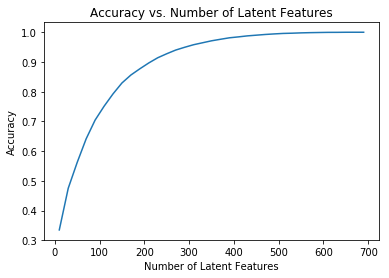

In [67]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [68]:
df_train = df.head(40000)
df_test = df.tail(5993)

In [69]:
df_train.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [70]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    
    user_item_train=create_user_item_matrix(df_train)
    user_item_test=create_user_item_matrix(df_test) 
    
    test_arts=list(user_item_test.columns)
    test_idx=list(user_item_test.index)
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [71]:
A=user_item_train.reindex(test_idx).dropna()
user_item_val=user_item_test.reindex(A.index)

In [72]:
print(user_item_val.shape)
user_item_val.head()

(20, 574)


article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1432.0,1433.0,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1443.0
user_id,,,,,,,,,,,,,,,,,,,,,
2917,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3024,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3093,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3193,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3527,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [73]:
len(test_idx), len(test_arts)

(682, 574)

In [74]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c,# letter here, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a,# letter here, 
    'How many movies can we make predictions for in the test set?':b, # letter here,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d# letter here
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [75]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train =np.linalg.svd(user_item_train) # fit svd similar to above then use the cells below

In [76]:
test_ids=list(set(user_item_train.index).intersection(set(test_idx)))
test_art_ids=list(set(user_item_train.columns).intersection(set(test_arts)))
test_rows=[list(user_item_train.index).index(id) for id in test_ids]
test_columns=[list(user_item_train.columns).index(id) for id in test_art_ids]

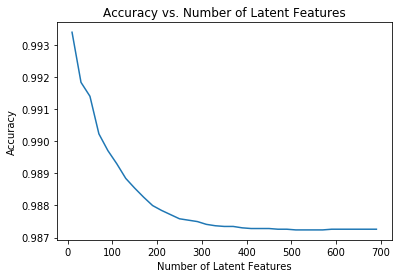

In [77]:
##Plot Accuracy

num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))[test_rows][:,test_columns]
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_est, user_item_val)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

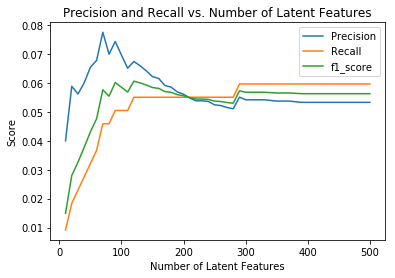

In [78]:
##Plot Precision, Recall and F1

num_latent_feats = np.arange(10,500+10,10)

precisions = []
recalls=[]

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))[test_rows][:,test_columns]
    
    # compute and store precision and recall
    test_pos=(user_item_val==1)
    pred_pos=(user_item_est==1)

    true_pos=(test_pos & pred_pos).sum().sum()
    
    
    precision= true_pos/(pred_pos.sum().sum())
    recall= true_pos/(test_pos.sum().sum())
    
    precisions.append(precision)
    recalls.append(recall)
    

precisions=np.array(precisions)
recalls=np.array(recalls)
f1_scores=2*(precisions*recalls)/(precisions+recalls)
    
plt.plot(num_latent_feats, precisions);
plt.plot(num_latent_feats, recalls);
plt.plot(num_latent_feats, f1_scores);
plt.xlabel('Number of Latent Features');
plt.ylabel('Score');
plt.title('Precision and Recall vs. Number of Latent Features');
plt.legend(['Precision', 'Recall', 'f1_score']);

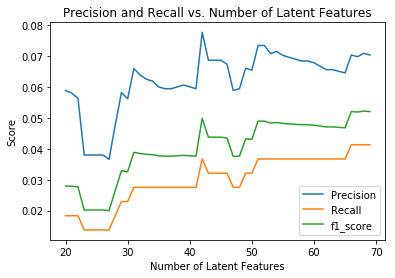

In [79]:
##Plot Precision, Recall and F1 but zoomed in 

num_latent_feats = np.arange(20,70,1)

precisions = []
recalls=[]

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))[test_rows][:,test_columns]
    
    # compute and store precision and recall
    test_pos=(user_item_val==1)
    pred_pos=(user_item_est==1)

    true_pos=(test_pos & pred_pos).sum().sum()
    
    
    precision= true_pos/(pred_pos.sum().sum())
    recall= true_pos/(test_pos.sum().sum())
    
    precisions.append(precision)
    recalls.append(recall)

precisions=np.array(precisions)
recalls=np.array(recalls)
f1_scores=2*(precisions*recalls)/(precisions+recalls)
    
plt.plot(num_latent_feats, precisions);
plt.plot(num_latent_feats, recalls);
plt.plot(num_latent_feats, f1_scores);
plt.xlabel('Number of Latent Features');
plt.ylabel('Score');
plt.title('Precision and Recall vs. Number of Latent Features');
plt.legend(['Precision', 'Recall', 'f1_score']);

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Your response here.**

Accuracy on the a training set is unsurprisngly an increasing function in the number of latent features. If we seperate into a testing set and plot accuracy verus latent features we see that accuracy decreases with the number of latent features. This is essentially because the most accurrate prediction we can make is a given user will not see any articles, since proportion of articles they interacted with is vanishingly small. Out of about 11000 possible interactions only about 218 happened in the test data.

Accuracy, Recall and f1 score ae much more relevent here. Precision peaks at a bit over 40 latent features and f1_score with it. There is only a small possible improvement in recall to be gained from additional features, so this seems a natural choice of feature number.

This method is a very poor indicator of performance however. The choice of train/test split is very strange, and as a result we get very little overlap between test and train data on which we can make meaningful predictions. I also run a test on the split I used for my content based 

In any case, once we had suitably refined our models we would likely wish to test their real world performance. This could be done through A/B testing. We are probably most interested in the performance on pre-existing users, since we have only really given one method for providing new users with recommendations. 

Since we have multiple models, some of which we may wish to blend, we may either run multiple experiments in tandem, and make pairwise  or group comparisons, or opt for a more iterative approach. This might look like testing two options, picking the better, and testing it against a new option and so on. The timescale of the experiment might look very different depending on the choices made, and this should be taken into account.

It would not really be appropriate here to test against a system with no, or totally random, recommendations. This would likely severely impact the user experience of one group, which would be at best questionably ethical and at worst detrimental to the overall platform. Comparisons against historical data would likely be flawed as there may be novelty bias, or unrelated changes in user behaviour, however such data could be used effectively to assign users to testing groups.

For either situation we would need to fix relative metrics in advance. The most natural here is a user-engagement metric, say mean number of articles interacted with. We might also be interested in user retention, perhaps measured by the number of users who interact with at least one article in the final $n$ days. Subsidiary items of interest might focus on the distribution of interactions. IBM might seek for example to increase the number of interactions with less popular articles, either as a goal in its own right or as part of a longer term aim to increase the diversity of articles.

Finally, the users of this site are likely more technologically minded than the global average. They may, therefore, be interested in being afforded the opportunity to choose the way recommendations are made themselves, within some preset limits. If a model blending collaborative and content based recommendations was used, the option might be given to chose the relative weighting of each method. The Steam store, for example, offers something along these lines.

It would be difficult, I expect, to get a good idea of the effectiveness of such an option in the short term as there would likely be a large novelty factor. Equally there may be objections if such a feature was rolled out long term to only a subset of users, especially if it proved popular. Conversely comparisons between users who engaged with this feature and those who did not would be poor as it may be biased. 

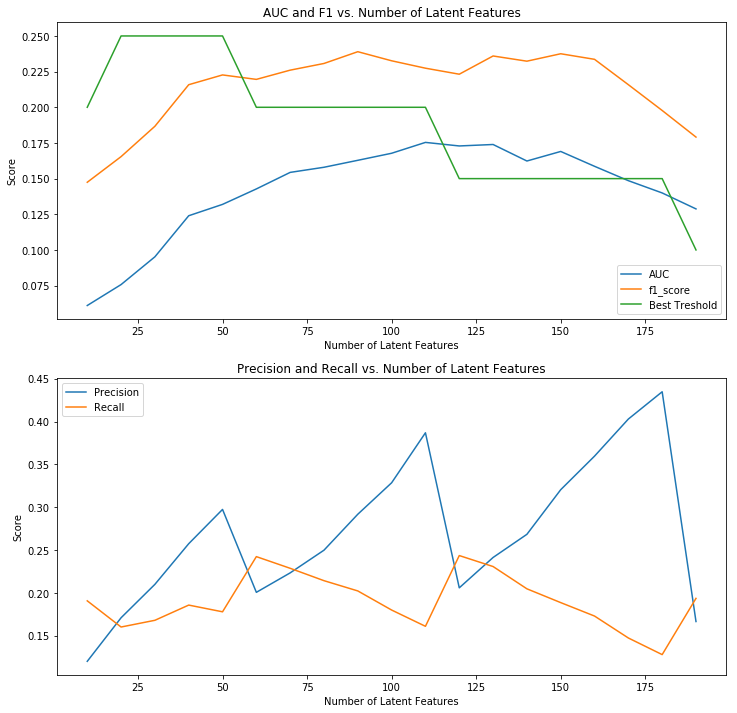

In [80]:
u_train, s_train, vt_train =np.linalg.svd(user_train)

test_size=sum([len(x) for x in test.values()])

thresholds=np.arange(0,0.5,0.05)

precision_dict={}
recall_dict={}
f1_dict={}

num_latent_feats = np.arange(10,200,10)
for k in num_latent_feats:
    
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    precisions = []
    recalls=[]
    for t in thresholds:
        
        # take dot product
        user_item_est = (np.dot(np.dot(u_new, s_new), vt_new) > t).astype(int)
    
        recommendation_locs=(user_item_est-user_train)[user_train !=1] ==1
    
        n_recs=recommendation_locs.sum().sum()
        n_correct=user_item.loc[known_users][recommendation_locs].sum().sum()
    
        # compute and store precision and recall
    
        if n_recs > 0:
            precision= n_correct/n_recs
            recall= n_correct
        else:
            precision = 1
            recall = 0
    
        precisions.append(precision)
        recalls.append(recall)
    precision_dict[k]=np.array(precisions)
    recall_dict[k]=np.array(recalls)/test_size
    
df_precision=pd.DataFrame(precision_dict, index=thresholds)
df_recall=pd.DataFrame(recall_dict, index=thresholds)
df_f1=2*df_precision*df_recall/(df_precision+df_recall)

auc_dict={}
f1_dict={}
thresh_dict={}

for k in df_recall.columns:
    auc_dict[k]=auc(df_recall[k], df_precision[k])
    f1_dict[k]=df_f1[k].max()
    thresh_dict[k]=df_f1[k][df_f1[k]==f1_dict[k]].index[0]
    precision_dict[k]=df_precision.loc[thresh_dict[k],k]
    recall_dict[k]=df_recall.loc[thresh_dict[k],k]
    
results=pd.DataFrame([auc_dict,f1_dict,thresh_dict, precision_dict, recall_dict],
                     index=['AUC score', 'Best f1-score', 'Best Threshold', 'Precision', 'Recall']).transpose()

f, axs = plt.subplots(2,1,figsize=(12,12))
plt.subplot(2,1,1)
plt.plot(results.iloc[:,0]);
plt.plot(results.iloc[:,1]);
plt.plot(results.iloc[:,2]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Score');
plt.title('AUC and F1 vs. Number of Latent Features');
plt.legend(['AUC', 'f1_score', 'Best Treshold']);


plt.subplot(2,1,2)
plt.plot(results.iloc[:,3]);
plt.plot(results.iloc[:,4]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Score');
plt.title('Precision and Recall vs. Number of Latent Features');
plt.legend(['Precision', 'Recall']);

With this split the recommender does pretty well. I expect I'd pick about 110 latent features and a threshold of 0.2. This gives a good mix of Precision and recall and corresponds to the highest f1-score.

These kinds of methods could be combined with the content and collobarative methods from before. If we swapped to FunkSVD in particular we could make some recommendations, set the correspondng entries to NaN and then perform and SVD decomposition with these values missing. This could then be used to make recommendations against a threshold as above.

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [81]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0